In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from skbio.stats.composition import clr, centralize, alr_inv
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from src.generators import ground_truth_edges
from src.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
#import yaml
%matplotlib inline

# CF simulation benchmark

In [2]:
results_dir = '../results/benchmark_output/CF_sims/'
microbes = load_table(os.path.join(results_dir, 'data/table.abs.microbes.0.biom'))
metabolites = load_table(os.path.join(results_dir, 'data/table.abs.metabolites.0.biom'))

In [3]:
mmvec_dir = 'abs/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
abs_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))

In [4]:
mmvec_dir = 'rel/mmvec/'
U = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'U.txt'))
Ubias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Ubias.txt'))
V = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'V.txt'))
Vbias = np.loadtxt(os.path.join(results_dir, mmvec_dir + 'Vbias.txt'))

U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
rel_ranks = pd.DataFrame(clr(alr_inv(U @ V)), index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))

In [5]:
# create separate ROC curves for each type of interaction
released = [('theta_p', 'I'),
            ('theta_p', 'P'),
            ('theta_f', 'F')]
consumed = [('theta_p', 'SA'),
            ('theta_f', 'SG')]
inhibited = [('theta_f', 'I')]

In [6]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])

In [7]:
#results_dir = '../results/benchmark_output/scale_benchmark/'
#microbes = load_table(os.path.join(results_dir, 'microbe_abs.biom'))
#metabolites = load_table(os.path.join(results_dir, 'metabolite_abs.biom'))

fnames = [
    ['pearson', 'abs_pearson.txt', 'rel_pearson.txt'],
    ['spearman', 'abs_spearman.txt', 'rel_spearman.txt'],
    ['sparcc', 'cor_matrix_abs_SparCC.csv', 'cor_matrix_rel_SparCC.csv'],
    ['phi', 'prop_matrix_abs_PHI.csv', 'prop_matrix_rel_PHI.csv'],
    ['rho', 'prop_matrix_abs_RHO.csv', 'prop_matrix_rel_RHO.csv'],
    ['spiec-easi', 'weights_abs_SPIECEASI.csv', 'weights_rel_SPIECEASI.csv']
]

In [8]:
def plot_scales(tool, abs_file, rel_file, axs):
    microbe_ids = microbes.ids(axis='observation')
    metabolite_ids = metabolites.ids(axis='observation')
    lw = 0.1
    if '.txt' in abs_file or '.txt' in rel_file:
        abs_ranks = pd.read_table(os.path.join(results_dir, 'abs/' + abs_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_table(os.path.join(results_dir, 'rel/' + rel_file),
                                  index_col=0).loc[microbe_ids, metabolite_ids]
    else:
        abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/' + abs_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]
        rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file),
                                index_col=0).loc[microbe_ids, metabolite_ids]        
        
    axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=lw,
                facecolors='none', edgecolors='k', alpha=0.5)   
        
    axs.tick_params(axis="x", labelsize=14)
    axs.tick_params(axis="y", labelsize=14)
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))    
    axs.set_title(tool, fontsize=18)
    axs.set_xlabel('Absolute', fontsize=14)
    axs.set_ylabel('Relative', fontsize=14)        

Text(0, 0.5, 'Relative')

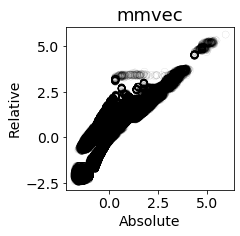

In [9]:
tool='mmvec'
fig, axs = plt.subplots(figsize=(3, 3))
axs.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel(), linewidth=0.1,
            facecolors='none', edgecolors='k', alpha=0.5, s=50)

axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)
axs.xaxis.set_major_locator(plt.MaxNLocator(4))
axs.yaxis.set_major_locator(plt.MaxNLocator(4))    
axs.set_title(tool, fontsize=18)
axs.set_xlabel('Absolute', fontsize=14)
axs.set_ylabel('Relative', fontsize=14)      

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


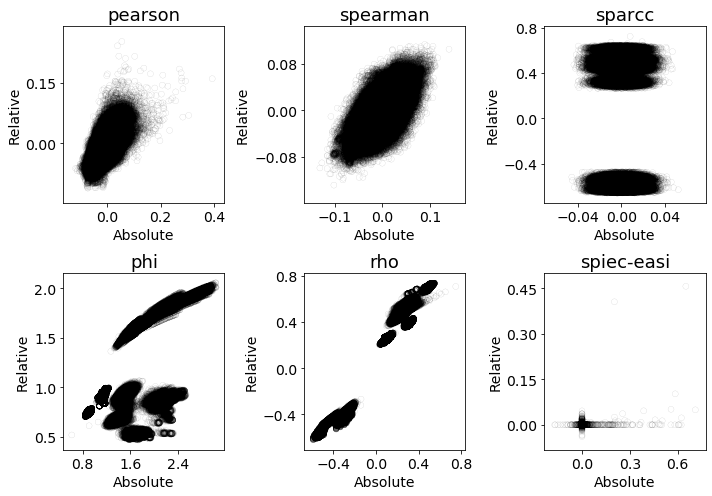

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for idx, res in enumerate(fnames):
    t, a, r = res
    i, j = idx // 3, idx % 3
    plot_scales(t, a, r, ax[i][j])
    
plt.tight_layout()    

# Precision-Recall curves

In [11]:
ranks = rel_ranks
pearson_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_pearson.txt'), index_col=0)
spearman_ranks = pd.read_table(os.path.join(results_dir, 'rel/rel_spearman.txt'), index_col=0)
sparcc_ranks = pd.read_csv(os.path.join(results_dir, 'rel/cor_matrix_rel_SparCC.csv'), 
                           index_col=0).loc[ranks.index, ranks.columns]
phi_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_PHI.csv'), 
                        index_col=0).loc[ranks.index, ranks.columns]
rho_ranks = pd.read_csv(os.path.join(results_dir, 'rel/prop_matrix_rel_RHO.csv'), 
                        index_col=0).loc[ranks.index, ranks.columns]
se_ranks = pd.read_csv(os.path.join(results_dir, 'rel/weights_rel_SPIECEASI.csv'),
                       index_col=0).loc[ranks.index, ranks.columns]

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
edges = pd.read_table(os.path.join(results_dir, 'data/edges.0.txt'), index_col=0)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
k=100
mmvec_res = _edge_roc_curve(ranks, edges, k_max=k, axis=1)
pearson_res = _edge_roc_curve(pearson_ranks, edges, k_max=k, axis=1)
spearman_res = _edge_roc_curve(spearman_ranks, edges, k_max=k, axis=1)
sparcc_res = _edge_roc_curve(sparcc_ranks, edges, k_max=k, axis=1)
phi_res = _edge_roc_curve(1 / phi_ranks, edges, k_max=k, axis=1)
rho_res = _edge_roc_curve(rho_ranks, edges, k_max=k, axis=1)
se_res = _edge_roc_curve(se_ranks, edges, k_max=k, axis=1)

In [14]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [15]:
for res in (mmvec_res, pearson_res, spearman_res, 
            sparcc_res, phi_res, rho_res, se_res):
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


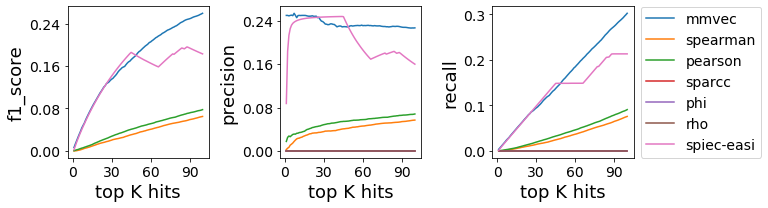

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

def plot_stats(ax, attr='F score'):
    ax.plot(mmvec_res[0][attr], label='mmvec')
    ax.plot(pearson_res[0][attr], label='spearman')
    ax.plot(spearman_res[0][attr], label='pearson')
    ax.plot(sparcc_res[0][attr], label='sparcc')
    ax.plot(phi_res[0][attr], label='phi')
    ax.plot(rho_res[0][attr], label='rho')
    ax.plot(se_res[0][attr], label='spiec-easi')
    ax.set_ylabel(attr, fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plot_stats(ax[0], attr='f1_score')
plot_stats(ax[1], attr='precision')
plot_stats(ax[2], attr='recall')
plt.tight_layout()
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)